In [20]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from dmrgwaytorho import *
from scipy import integrate,special
from scipy.linalg import eig,eigh,eigvals,eigvalsh
from scipy.sparse.linalg import eigs
import pickle 
import os
from IPython.display import Audio
from permutations import get_dicts, rho_3,g_s,rho_3new,rho_2new
import qutip as q

sound_file=os.path.basename("C:Users/alfre/Ergotropy/logbook_and_notebooks/Exclamation.wav")

In [21]:
lambdarange=np.linspace(0.1,2)

In [23]:
sX = np.array([[0, 1], [1, 0]], dtype='d') 
Id = np.array([[1, 0], [0, 1]], dtype='d')

def H2(Sx1, Sx2):  # two-site part of H
    
    return -0.5*(kron(Sx1, Sx2.conjugate().transpose()))

Audio(filename=sound_file,autoplay=True)

h=0.0001
rho_dict_exp={}
for lam in lambdarange:

    H1 = -0.5*lam*np.array([[1, 0], [0, -1]], dtype='d') -h*np.array([[0, 1], [1, 0]], dtype='d') # single-site portion of H 

    site = Block(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "conn_Sx": sX,
        })

    rho_dict_exp[lam]=infinite_system_algorithm(site,site, 100, 30,H2)

    print(lam)
Audio(filename=sound_file,autoplay=True)

0.1


KeyboardInterrupt: 

In [4]:
%load_ext autoreload
%autoreload

dic,perm=get_dicts()

g=g_s(lambdarange)

rho_dic_theo={}
for l in lambdarange:
    rho_dic_theo[l]=rho_2new(dic,perm,g,l)


True
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
0.9999999999999998


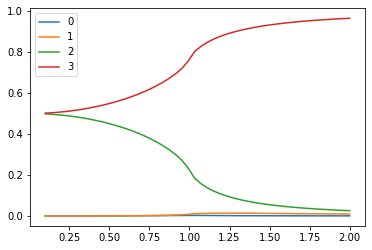

In [5]:
check=0
def check_herm(a, tol=1e-5):
    return np.all(np.abs(a-a.conjugate().transpose()) < tol)
print(check_herm(np.array([[0,-1j],[1j,0]])))
print([check_herm(np.array([rho_dic_theo[x]])) for x in rho_dic_theo])
for k in range(4):
        
    theovec=np.zeros_like(lambdarange)
    
    
    for i,el in enumerate(lambdarange):
        theovec[i]=eigvalsh(rho_dic_theo[el])[k]
        
    check=check+theovec[10]
    plt.plot(lambdarange,theovec,label=k)
print(check)
plt.legend()
plt.show()    

In [12]:
rho_effective={}
for el in lambdarange:
    if el<1:
        rho_effective[el]=0.5*rho_dict_exp[el][0]+0.5*rho_dict_exp[el][1]
    else:
        rho_effective[el]=rho_dict_exp[el][0]

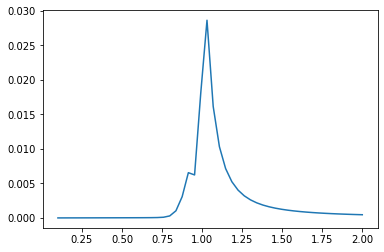

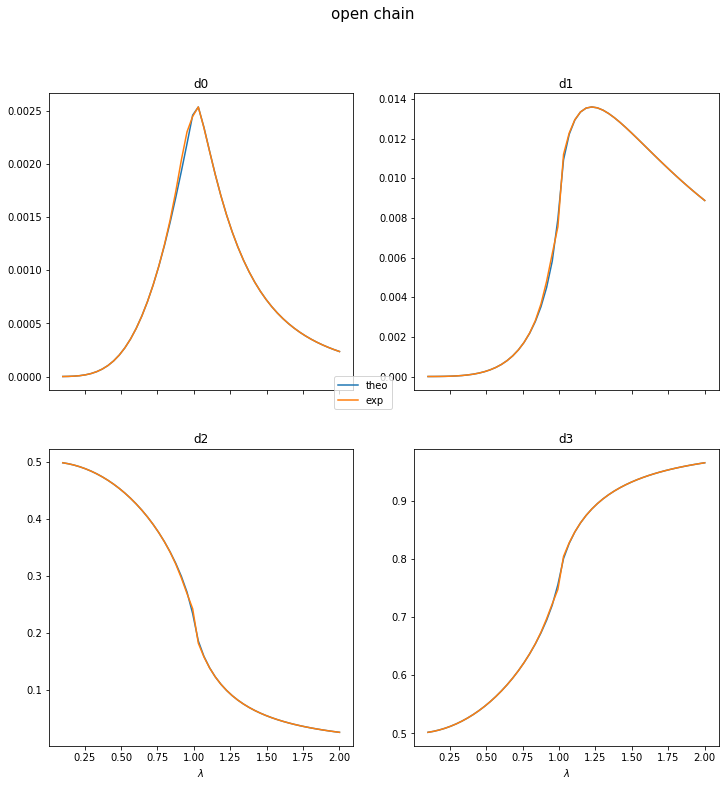

In [13]:
diff_lis=[None]*len(lambdarange)
for i,l in enumerate(lambdarange):
    diff_lis[i]=rho_dic_theo[l]-rho_effective[l]
eig_diff_lis=[eigvalsh(x) for x in diff_lis]
sum_eig_diff=[sum(np.abs(vec)) for vec in eig_diff_lis ]
plt.plot(lambdarange,sum_eig_diff)

fig, axs = plt.subplots(2, 2,sharex=True,figsize=[12,12])

ind=[(x,y) for x in range(2) for y in range(2)]

for k in range(4):

    specvec= np.zeros_like(lambdarange)
    theovec=np.zeros_like(lambdarange)

    for i,el in enumerate(lambdarange):
        specvec[i]=np.sort(eigvalsh(rho_effective[el]))[k]
        
        theovec[i]=np.sort(eigvalsh(rho_dic_theo[el]))[k]

    axs[ind[k]].plot(lambdarange,theovec,label="theo")
    axs[ind[k]].plot(lambdarange,specvec,label="exp")
    axs[ind[k]].set_title('d'+str(k))
handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
fig.suptitle(r"open chain",fontsize=15)
axs[1,1].set_xlabel(r"$\lambda$")
axs[1,0].set_xlabel(r"$\lambda$")
plt.show()    

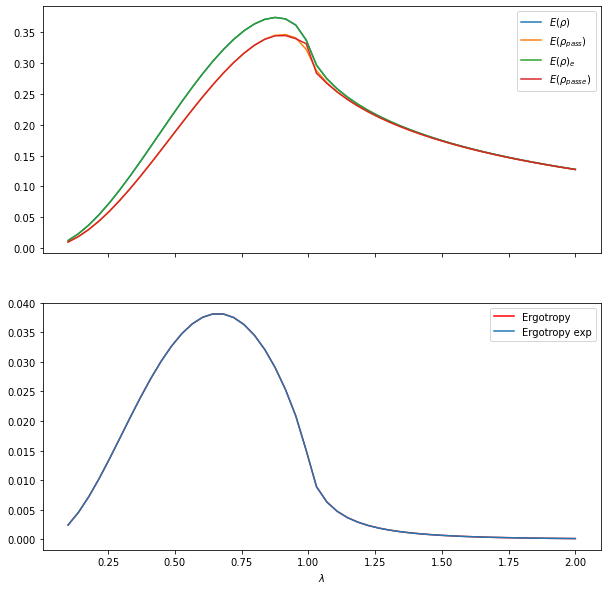

In [14]:
def Hamiltonian(lam):
    return -(q.tensor(q.sigmax(),q.sigmax()))-lam*q.tensor(q.sigmaz(),q.identity(2))-lam*q.tensor(q.identity(2),q.sigmaz())
energies_pass_theo=[]
energies_subs_theo=[]

for j,l in enumerate(lambdarange):    

    
    eigval,eigstat=eigh(rho_dic_theo[l])
    
    qrho_2=q.Qobj(rho_dic_theo[l],dims=[[2, 2], [2, 2]])

    reduced_H_matr=Hamiltonian(l)
    
    h_eigval, h_eigvec= reduced_H_matr.eigenstates()
    
    rho_pass=q.Qobj()
   
    sortdesc=np.sort(eigval)[::-1]
    for i in range(len(eigval)):    
        rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])
    
    ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
    ener_subs=q.expect(qrho_2,reduced_H_matr)-h_eigval[0]

    
    energies_pass_theo.append(ener_pass)
    energies_subs_theo.append(ener_subs)
    
fig, axs = plt.subplots(2,sharex=True,figsize=[10,10])
axs[0].plot(lambdarange,energies_subs_theo,label=r"$E(\rho)$")
axs[0].plot(lambdarange,energies_pass_theo,label=r"$E(\rho_{pass})$")
axs[1].plot(lambdarange,(np.array(energies_subs_theo)-np.array(energies_pass_theo)),color="r",label="Ergotropy")
plt.xlabel(r"$\lambda$")
axs[0].legend()
axs[1].legend()

energies_pass_exp=[]
energies_subs_exp=[]

for j,l in enumerate(lambdarange):    

    
    eigval,eigstat=eigh(rho_effective[l])
    
    qrho_2=q.Qobj(rho_dic_theo[l],dims=[[2, 2], [2, 2]])

    reduced_H_matr=Hamiltonian(l)
    
    h_eigval, h_eigvec= reduced_H_matr.eigenstates()
    
    rho_pass=q.Qobj()
   
    sortdesc=np.sort(eigval)[::-1]
    for i in range(len(eigval)):    
        rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])
    
    ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
    ener_subs=q.expect(qrho_2,reduced_H_matr)-h_eigval[0]

    
    energies_pass_exp.append(ener_pass)
    energies_subs_exp.append(ener_subs)
    
axs[0].plot(lambdarange,energies_subs_exp,label=r"$E(\rho)_{e}$")
axs[0].plot(lambdarange,energies_pass_exp,label=r"$E(\rho_{pass e})$")
axs[1].plot(lambdarange,(np.array(energies_subs_theo)-np.array(energies_pass_theo)),label="Ergotropy exp")
plt.xlabel(r"$\lambda$")
axs[0].legend()
axs[1].legend()
plt.show()

In [19]:
print(rho_effective[0.1])

[[ 2.75968571e-01 -4.41272779e-07 -4.41272779e-07  2.49687108e-01]
 [-4.41272779e-07  2.49061146e-01  2.49060804e-01  4.33685643e-07]
 [-4.41272779e-07  2.49060804e-01  2.49061146e-01  4.33685643e-07]
 [ 2.49687108e-01  4.33685643e-07  4.33685643e-07  2.25909138e-01]]
